# Analyze Amazon electronics dataset

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
savepath = "dataset/precomputed/electronics"

In [2]:
all_class_colors = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1)]

label_to_name = {
    0:"Desktops",
    1:"Data Storage",
    2:"Laptops",
    3:"Monitors",
    4:"Computer Components",
    5:"Video Projectors",
    6:"Routers",
    7:"Tablets",
    8:"Networking Products",
    9:"Webcams"}

## Load precomputed graph and lens

In [3]:
labels = np.load(f"{savepath}/labels.npy")
with open(f"{savepath}/train_nodes.txt","r") as f:
    lines = f.readlines()
    train_nodes = [int(i.strip()) for i in lines]
with open(f"{savepath}/val_nodes.txt","r") as f:
    lines = f.readlines()
    val_nodes = [int(i.strip()) for i in lines]
with open(f"{savepath}/test_nodes.txt","r") as f:
    lines = f.readlines()
    test_nodes = [int(i.strip()) for i in lines]
ei,ej,e = [],[],[]
with open(f"{savepath}/edge_list.txt","r") as f:
    lines = f.readlines()
    num_nodes = int(lines[0].strip().split(' ')[0])
    for line in lines[1::]:
        line = line.strip().split(' ')
        ei.append(int(line[0]))
        ej.append(int(line[1]))
        e.append(int(line[2]))
G = sp.csr_matrix((e,(ei,ej)),(num_nodes,num_nodes))
preds = np.load(f"{savepath}/prediction_lens.npy")
pred_labels = np.argmax(preds,1)

## Compute Reeb graph and estimated errors

In [4]:
from GTDA.GTDA_utils import compute_reeb, NN_model
from GTDA.GTDA import GTDA

nn_model = NN_model()
nn_model.preds = preds
nn_model.labels = labels
nn_model.A = G
nn_model.train_mask = np.zeros(G.shape[0])
nn_model.train_mask[train_nodes] = 1
nn_model.val_mask = np.zeros(G.shape[0])
nn_model.val_mask[val_nodes] = 1
nn_model.test_mask = np.zeros(G.shape[0])
nn_model.test_mask[test_nodes] = 1
smallest_component = 100
overlap = 0.01
labels_to_eval = list(range(preds.shape[1]))
GTDA_record = compute_reeb(GTDA,nn_model,labels_to_eval,smallest_component,overlap,extra_lens=None,
    node_size_thd=5,reeb_component_thd=5,nprocs=10,device='cuda',nsteps_mixing=20)

Preprocess lens..
Merge reeb nodes...
Build reeb graph...
Total time for building reeb graph is 11.060611963272095 seconds
Compute mixing rate for each sample


In [5]:
from GTDA.GTDA_utils import save_to_json
save_to_json(GTDA_record, nn_model, savepath, label_to_name)

## Visualize a component of GTDA results

In [7]:
import gzip
from collections import Counter
import pandas as pd

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
      yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

meta_df = getDF(f'dataset/meta_Electronics_2014.json.gz')
meta_categories = {}
all_asin = meta_df['asin'].values
raw_categories = meta_df['categories'].values
for i in range(len(all_asin)):
    meta_categories[all_asin[i]] = raw_categories[i][0]

with open(f"{savepath}/product_asin.txt","r") as f:
    lines = f.readlines()
    selected_asin = [i.strip() for i in lines]

100%|██████████| 11/11 [00:00<00:00, 1181.71it/s]

Top 3 most common subcategories of Networking Products in this component are:
[('Network Adapters', 154), ('Print Servers', 53), ('Hubs', 20)]


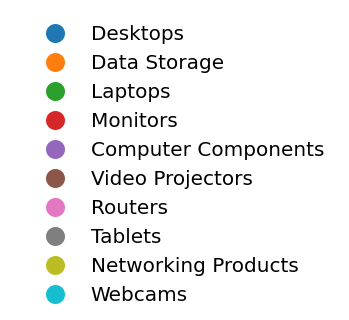

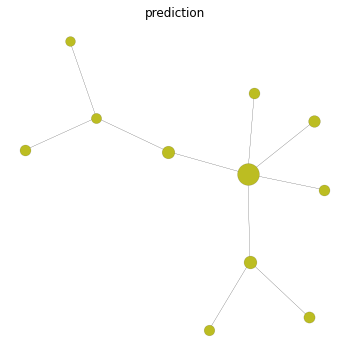

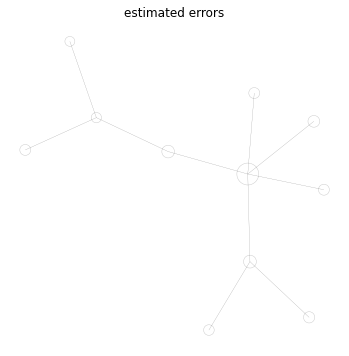

In [10]:
import networkx as nx
from GTDA.GTDA_utils import find_components, plot_reeb_component
import pandas as pd
from matplotlib.lines import Line2D

gtda = GTDA_record['gtda']
g_reeb = GTDA_record['g_reeb']
reeb_components = find_components(g_reeb,size_thd=0)[1]
component = reeb_components[9]
g_sub = g_reeb[component,:][:,component]
xcoords = np.zeros(len(component))
ycoords = np.zeros(len(component))
pos_tmp = nx.kamada_kawai_layout(nx.from_scipy_sparse_matrix(g_sub))
for i in range(len(component)):
    xcoords[i] = pos_tmp[i][0]
    ycoords[i] = pos_tmp[i][1]
df = pd.DataFrame({'x':xcoords,'y':ycoords,'sizes':40*gtda.node_sizes[gtda.filtered_nodes[component]]**0.5})

patches = []
for label_to_eval in labels_to_eval:
    patches.append(
        Line2D(
            [0],[0],marker='o',markerfacecolor=all_class_colors[label_to_eval],
            label=f"{label_to_name[label_to_eval]}",color='w',markersize=20))
fig_legend,ax_legend = plt.subplots(figsize=(6, 1))
ax_legend.legend(handles=patches,fontsize=20,framealpha=0,ncol=1)
ax_legend.axis('off')

fig,ax = plt.subplots(figsize=(6,6))
fig,ax = plot_reeb_component(g_sub,df,gtda.node_colors_class[gtda.filtered_nodes[component]],
    labels_to_eval=labels_to_eval,all_class_colors=all_class_colors,fig=fig,ax=ax)
ax.set_title('prediction')

fig,ax = plt.subplots(figsize=(6,6))
node_colors = [(1,0,0,i) for i in gtda.node_colors_mixing[gtda.filtered_nodes[component]]]
fig,ax = plot_reeb_component(g_sub,df,node_colors,
    labels_to_eval=labels_to_eval,all_class_colors=all_class_colors,fig=fig,ax=ax,is_plotting_error=True)
ax.set_title('estimated errors')

nodes = []
for reeb_node in component:
    nodes += gtda.final_components_filtered[gtda.filtered_nodes[reeb_node]]
selected_cats = []
for node in nodes:
    if labels[node] == 8:
        selected_cats += meta_categories[selected_asin[node]][3:4]
print("Top 3 most common subcategories of Networking Products in this component are:")
print(Counter(selected_cats).most_common(3))

100%|██████████| 14/14 [00:00<00:00, 164.36it/s]

Top 3 most common subcategories of Networking Products in this component are:
[('Modems', 167), ('Wireless Access Points', 45), ('Switches', 19)]


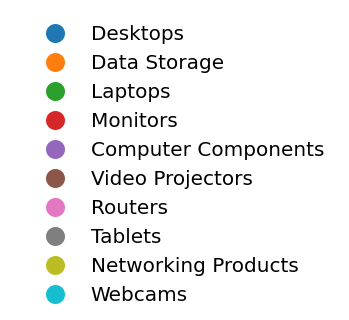

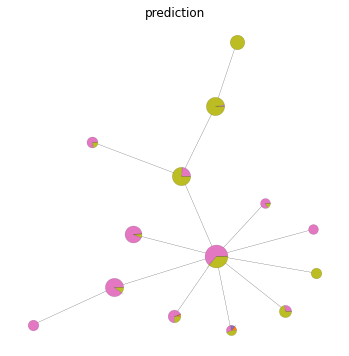

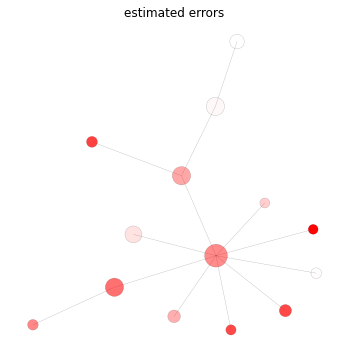

In [11]:
component = reeb_components[13]
g_sub = g_reeb[component,:][:,component]
xcoords = np.zeros(len(component))
ycoords = np.zeros(len(component))
pos_tmp = nx.kamada_kawai_layout(nx.from_scipy_sparse_matrix(g_sub))
for i in range(len(component)):
    xcoords[i] = pos_tmp[i][0]
    ycoords[i] = pos_tmp[i][1]
df = pd.DataFrame({'x':xcoords,'y':ycoords,'sizes':40*gtda.node_sizes[gtda.filtered_nodes[component]]**0.5})

patches = []
for label_to_eval in labels_to_eval:
    patches.append(
        Line2D(
            [0],[0],marker='o',markerfacecolor=all_class_colors[label_to_eval],
            label=f"{label_to_name[label_to_eval]}",color='w',markersize=20))
fig_legend,ax_legend = plt.subplots(figsize=(6, 1))
ax_legend.legend(handles=patches,fontsize=20,framealpha=0,ncol=1)
ax_legend.axis('off')

fig,ax = plt.subplots(figsize=(6,6))
fig,ax = plot_reeb_component(g_sub,df,gtda.node_colors_class[gtda.filtered_nodes[component]],
    labels_to_eval=labels_to_eval,all_class_colors=all_class_colors,fig=fig,ax=ax)
ax.set_title('prediction')

fig,ax = plt.subplots(figsize=(6,6))
node_colors = [(1,0,0,i) for i in gtda.node_colors_mixing[gtda.filtered_nodes[component]]]
fig,ax = plot_reeb_component(g_sub,df,node_colors,
    labels_to_eval=labels_to_eval,all_class_colors=all_class_colors,fig=fig,ax=ax,is_plotting_error=True)
ax.set_title('estimated errors')

nodes = []
for reeb_node in component:
    nodes += gtda.final_components_filtered[gtda.filtered_nodes[reeb_node]]
selected_cats = []
for node in nodes:
    if labels[node] == 8:
        selected_cats += meta_categories[selected_asin[node]][3:4]
print("Top 3 most common subcategories of Networking Products in this component are:")
print(Counter(selected_cats).most_common(3))